
# LOG: LeNet Implementation (In partial fulfilment of the course NNFL )   

GROUP 1 (12 Feb 2020): 

Added vanilla implementation of LeNet.

Includes layers uptil F6 and its activation
Only forward propagation is implemented

Passing on to Group 13 for further work

************************************************************************
Authors : Arshia Arya, Harnoor Dhingra, Ishita Mediratta, Jahanvi Shah, Nidhi Ravishankar
************************************************************************

######################################################################################################

GROUP 13 (14 Feb 2020): 

Added RBF output layer of LeNet.

Includes manually set Bitmaps (dim: 12*7) for digits 0-9.

Forward pass for training & inference for RBF layer is implemented. (Backpropagation not implemented)

************************************************************************
Authors : Sharad Chitlangia, Rajaswa Patil, Advait Pradhan, Vaibhav Mittal, Urvil Jivani, Kush Jain
************************************************************************

In [0]:
import numpy as np 
import sys
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
import time
import struct
import math
import random

In [2]:

from keras.datasets import mnist
# Load dataset as train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [3]:
n_m, n_m_test = len(y_train), len(y_test)
print("The shape of training image:", x_train.shape)
print("The shape of testing image: ", x_test.shape)
print("Length of the training set: ", n_m)
print("Length of the training set: ", n_m_test)
print("Shape of a single image: ", x_train[0].shape)

The shape of training image: (60000, 28, 28)
The shape of testing image:  (10000, 28, 28)
Length of the training set:  60000
Length of the training set:  10000
Shape of a single image:  (28, 28)


Before feeding the images into the ConvNet, zero-padding with pad=2 is used. The MNIST data that TensorFlow pre-loads comes as 28x28x1 images.

However, the LeNet architecture only accepts 32x32xC images, where C is the number of color channels.
In order to reformat the MNIST data into a shape that LeNet will accept, we pad the data with two rows of zeros on the top and bottom, and two columns of zeros on the left and right (28+2+2 = 32).


The normalization method used in the original paper of LeNet5 is scaling and translating the pixel values to the range of [-0.1, 1.175], which makes the mean of pixel values in each image approxiamtely equals to 0.



In [4]:
# Set numeric type to float32 from uint8
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Reshape the dataset into 4D array
x_train = x_train.reshape(x_train.shape[0], 28,28,1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

x_train = np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
x_test  = np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

# Normalize value to [-0.1, 1.175]
x_train = ((1.275*x_train)/255) - 0.1
x_test = ((1.275*x_test)/255) - 0.1


print("The shape of training image with padding:", x_train.shape)
print("The shape of testing image with padding: ", x_test.shape)

The shape of training image with padding: (60000, 32, 32, 1)
The shape of testing image with padding:  (10000, 32, 32, 1)


# Structure of LeNet5

## Defining basic blocks

## 1. Convolution

In [0]:
'''
Finding forward propagation for a convolution function 
'''

import numpy as np 
from scipy.signal import convolve2d

def conv_forward(A_prev, W, b, stride=1):
    """
    Input:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_prev, n_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    stride -- integer
        
    Output:
    Z -- conv output, numpy array of shape (m, n, n, n_C)
    """
    (m, n_prev, n_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    n = int((n_prev - f)/stride + 1)

    Z = np.zeros((m, n, n, n_C))
    
    for h in range(n):                            
        for w in range(n):                       
            A_slice_prev = A_prev[:, h*stride:h*stride+f, w*stride:w*stride+f, :]
            Z[:, h, w, :] = np.tensordot(A_slice_prev, W, axes=([1,2,3],[0,1,2])) + b
                            
    assert(Z.shape == (m, n, n, n_C)) 
    return Z

## 2. SubSample Layer

In [0]:
def pool_forward(A_prev, stride, filt):
    """
    Input:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_prev, n_prev, n_C_prev)
    stride -- integer
    filt -- size of kernel
    
    Output:
    A -- average pooling output, numpy array of shape (m, n, n, n_C)
    """
    (m, n_prev, n_prev, n_C_prev) = A_prev.shape
    f = filt
    
    n = int(1 + (n_prev - f) / stride)
    
    n_C = n_C_prev

    A = np.zeros((m, n, n, n_C))      
    
    for h in range(n):                      
        for w in range(n):                  

            A_prev_slice = A_prev[:, h*stride:h*stride+f, w*stride:w*stride+f, :]  
            A[:, h, w, :] = np.average(A_prev_slice, axis=(1,2))

    assert(A.shape == (m, n, n, n_C))
    return A

## 3. Activation Tanh 

In [0]:
def TanH(x):
    return 1.7159*np.tanh(2*x/3)

## Function to initialise weights and biases

In [0]:
def initialize(kernel_shape):
    b_shape = (1,1,1,kernel_shape[-1]) if len(kernel_shape)==4 else (kernel_shape[-1],)
    Fan_in = np.prod(kernel_shape)/kernel_shape[-1]
    weight = np.random.uniform(-2.4/Fan_in, 2.4/Fan_in,  kernel_shape) 
    bias   = np.ones(b_shape)*0.01
    return weight, bias

## Defining Layer Objects

## 1. Convolution Layer

In [0]:
class ConvLayer(object):
    def __init__(self, kernel_shape, stride):
        """
        kernel_shape: (n_f, n_f, n_C_prev, n_C)
        stride -- integer
        """
        self.stride = stride
        self.weight, self.bias = initialize(kernel_shape)
        
    def foward_prop(self, input_map):
        return conv_forward(input_map, self.weight, self.bias, self.stride)

In [0]:
C3_mapping = [[0,1,2],[1,2,3],[2,3,4],[3,4,5],[4,5,0],[5,0,1],\
              [0,1,2,3],[1,2,3,4],[2,3,4,5],[3,4,5,0],[4,5,0,1],[5,0,1,2],\
              [0,1,3,4],[1,2,4,5],[0,2,3,5],\
              [0,1,2,3,4,5]]

class ConvLayer_C3(object):
    def __init__(self, kernel_shape, stride, mapping):
        """
        kernel_shape: (n_f, n_f, n_C_prev, n_C)
        stride -- integer
        """
        self.stride = stride
        self.mapping = mapping
        self.wb = []      
        for i in range(len(self.mapping)):
            weight_shape = (kernel_shape[0], kernel_shape[1], len(self.mapping[i]), 1)
            w, b = initialize(weight_shape)
            self.wb.append([w, b])
        
    def foward_prop(self, input_map):
        self.inputmap_shape = input_map.shape 
        output_maps = []
        for i in range(len(self.mapping)):
            output_map = conv_forward(input_map[:,:,:,self.mapping[i]], self.wb[i][0], self.wb[i][1], self.stride)
            output_maps.append(output_map)
        output_maps = np.swapaxes(np.array(output_maps),0,4)[0]
        return output_maps

## 2. Subsampling Layer

In [0]:
class PoolingLayer(object):
    def __init__(self, stride, filt):
        self.stride = stride
        self.filt = filt
        
    def foward_prop(self, input_map):   
        A = pool_forward(input_map, self.stride, self.filt)
        return A

## 3. Tanh Layer

In [0]:
class Activation(object):
    def __init__(self, mode):    
        self.act = mode
        
    def foward_prop(self, input_image): 
        self.input_image = input_image
        return TanH(input_image)

## 4. Fully-Connected Layer

In [0]:
class FCLayer(object):
    def __init__(self, weight_shape): 
        
        # Initialization
        self.weight, self.bias = initialize(weight_shape)
        
    def foward_prop(self, input_array):
        self.input_array = input_array  
        return np.matmul(self.input_array, self.weight)

## 5. Radial Basis Function

The output layer of LeNet-5 consists of 10 Radial Basis Function Units, following Euclidean norms over the radial distances. Separate forward passes are implemented for training and inference.

In [0]:
class RBFLayer(object):
    def __init__(self, bitmaps):
        '''
        ARGUMENTS:
          bitmaps: numpy array of dimension 12x7, one for each class

        RETURNS:
          loss: squared-error sum of RBF distances
          class_pred: the predicted class with the minimum distance
        '''

        self.bitmaps = bitmaps    #Initializing Bitmaps
        
    def forward_prop(self, input_array, label):
        self.labelled_weight = []
        for i in range(input_array.shape[0]):
            self.labelled_weight.append(self.bitmaps[label[i]])   #Getting Bitmaps of correct class for each sample
        subtract_weight_train = input_array - np.array(self.labelled_weight)    #Finding loss wrt to correct class 
        subtract_weight_test = input_array[:, np.newaxis, :] - np.array(input_array.shape[0]*self.bitmaps)    #Finding loss wrt to all the classes for inference
        predictions = np.sum(np.power(subtract_weight_test, 2), axis=2)   
        class_pred = np.argmin(predictions, axis=1)   #Selecting the class with minm loss as the predicted class
        loss = np.sum(np.power(subtract_weight_train, 2), axis=1)
        return loss, class_pred

# BitMaps

BITMAPS are manually set as matrices of dimension 12*7, such that each bitmap resembles closely to the 2D Image representation of the particular ASCII character. (Source: LeNet-5. Le Cunn 1998)

In [0]:
'''
BITMAP ARRAYS for DIGIT 0-9
'''

bitmap = np.zeros((10,84))
bitmap[0]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, +1, +1, +1, -1, -1] + \
    [-1, +1, +1, -1, +1, +1, -1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, -1, +1, +1, -1] + \
    [-1, -1, +1, +1, +1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[1]=np.array([
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, +1, +1, +1, -1, -1] + \
    [-1, +1, +1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[2]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, +1, +1, -1] + \
    [-1, -1, +1, +1, +1, -1, -1] + \
    [-1, +1, +1, -1, -1, -1, -1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [+1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[3]=np.array([
    [+1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, +1, +1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[4]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, +1, +1, -1, -1, +1, +1] + \
    [-1, +1, +1, -1, -1, +1, +1] + \
    [+1, +1, +1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, +1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] \
])
bitmap[5]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [+1, +1, +1, +1, +1, +1, +1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [-1, +1, +1, +1, +1, -1, -1] + \
    [-1, -1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[6]=np.array([
    [-1, -1, +1, +1, +1, +1, -1] + \
    [-1, +1, +1, -1, -1, -1, -1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [+1, +1, -1, -1, -1, -1, -1] + \
    [+1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, +1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, +1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[7]=np.array([
    [+1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, +1, +1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, -1, +1, +1, -1, -1] + \
    [-1, -1, +1, +1, -1, -1, -1] + \
    [-1, -1, +1, +1, -1, -1, -1] + \
    [-1, -1, +1, +1, -1, -1, -1] + \
    [-1, -1, +1, +1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[8]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])
bitmap[9]=np.array([
    [-1, +1, +1, +1, +1, +1, -1] + \
    [+1, +1, -1, -1, +1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, -1, +1, +1] + \
    [+1, +1, -1, -1, +1, +1, +1] + \
    [-1, +1, +1, +1, +1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, -1, +1, +1] + \
    [-1, -1, -1, -1, +1, +1, -1] + \
    [-1, +1, +1, +1, +1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] + \
    [-1, -1, -1, -1, -1, -1, -1] \
])


# LeNet5 Model

In [0]:
class LeNet5(object):
    def __init__(self, rbf_bitmaps):
        
        self.C1 = ConvLayer(kernel_shape=(5,5,1,6), stride=1)
        self.a1 = Activation("Tanh")
        self.S2 = PoolingLayer(stride=2, filt=2)
        
        self.C3 = ConvLayer_C3(kernel_shape=(5,5,6,16), stride=1, mapping=C3_mapping)
        self.a2 = Activation("Tanh")
        self.S4 = PoolingLayer(stride=2, filt=2)
        
        self.C5 = ConvLayer(kernel_shape=(5,5,16,120), stride=1)
        self.a3 = Activation("Tanh")

        self.F6 = FCLayer(weight_shape=(120,84))
        self.a4 = Activation("Tanh")
        
        self.rbf = RBFLayer(bitmap)
            
    def Forward_Propagation(self, input_image, labels): 
        self.C1_FP = self.C1.foward_prop(input_image)
        self.a1_FP = self.a1.foward_prop(self.C1_FP)
        self.S2_FP = self.S2.foward_prop(self.a1_FP)

        self.C3_FP = self.C3.foward_prop(self.S2_FP)
        self.a2_FP = self.a2.foward_prop(self.C3_FP)
        self.S4_FP = self.S4.foward_prop(self.a2_FP)

        self.C5_FP = self.C5.foward_prop(self.S4_FP)
        self.a3_FP = self.a3.foward_prop(self.C5_FP)

        self.flatten = self.a3_FP[:,0,0,:]
        self.F6_FP = self.F6.foward_prop(self.flatten)
        self.a4_FP = self.a4.foward_prop(self.F6_FP)

        self.loss, self.pred = self.rbf.forward_prop(self.a4_FP, labels) 
        
        return self.loss, self.pred, self.a4_FP

In [0]:
ConvNet = LeNet5(rbf_bitmaps=bitmap)

# Filters (Kernels) 

The initialise function uses gaussian distribution with mean = 0 and variance = 0.1 to initialise the weights i.e. filters and biases for the first time

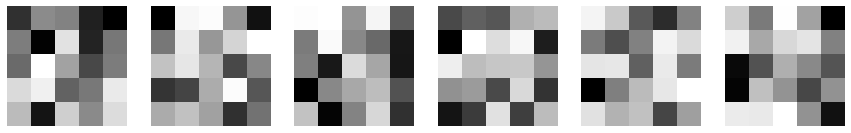

In [18]:
fig, axarr = plt.subplots(1,6,figsize=(15,15))
for i in range(6):
    axarr[i].axis('off')
    axarr[i].imshow(ConvNet.C1.weight[:,:,0,i], cmap=mpl.cm.Greys)

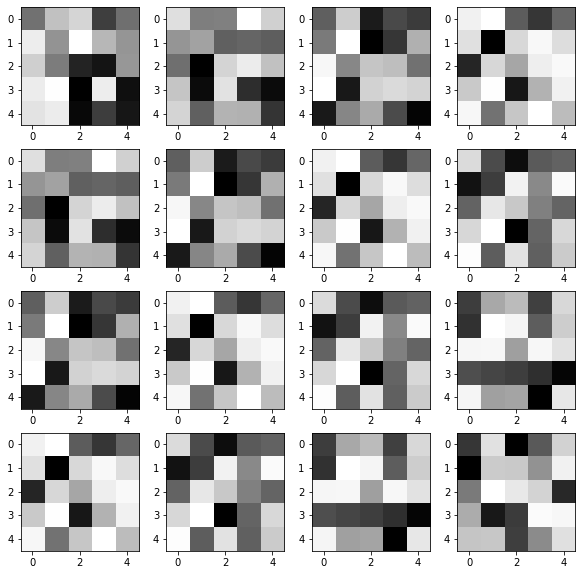

In [19]:
fig, axarr = plt.subplots(4,4,figsize=(10,10))
C3_kernel = np.array(ConvNet.C3.wb)[:,0].T
j = 0
row = 0
for i in range(4):
    for j in range(4):
        
        if i+j<6:
            k=3
        elif i+j<15:
            k=4
        else:
            k=6
        axarr[i,j].imshow(C3_kernel[i+j][:,:,0,0], cmap=mpl.cm.Greys)

# Running a single pass

## Sample Image

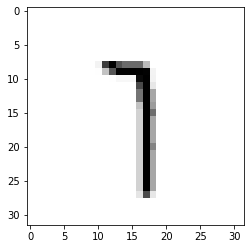

In [20]:
index = np.random.randint(60000,size=2)
x_sample = x_train[index,:,:,:]
y_sample = y_train[index]
plt.imshow(x_sample[0,:,:,0], cmap=mpl.cm.Greys)

# RBF

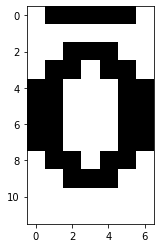

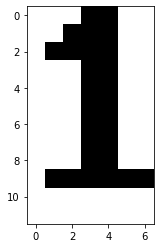

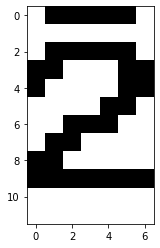

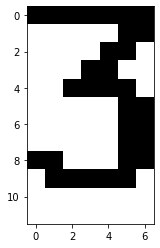

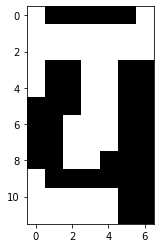

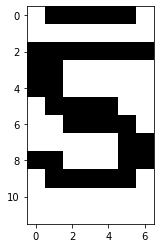

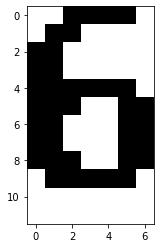

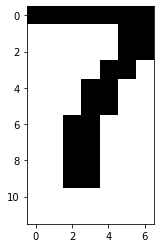

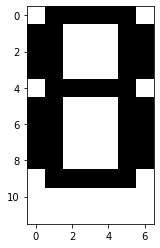

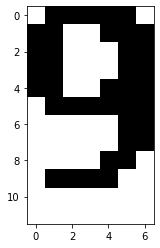

In [21]:
#Visualizing the BITMAPS
for i in range(10):
    plt.imshow(bitmap[i].reshape(12,7), cmap="Greys")
    plt.pause(0.1)

In [22]:
#Forward Pass with RBF Output Layer
out, class_pred, a4_FP = ConvNet.Forward_Propagation(x_train[0:5], y_train[0:5])

y_true = y_train[0:5]
print("Sample Predictions for a sample of 5 images\n", 
      "Class Predictions: ", class_pred, "\n", 
      "True labels: ", y_true)

print("Loss: ", np.mean(out))

Sample Predictions for a sample of 5 images
 Class Predictions:  [9 9 9 5 7] 
 True labels:  [5 0 4 1 9]
Loss:  84.04856966282448


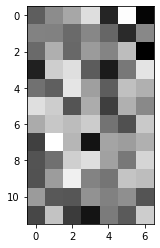

In [23]:
#Visualizing activations from RBF Inputs
plt.imshow(ConvNet.Forward_Propagation(x_train[0:2], y_train[0:2])[2][1].reshape(12, 7), cmap='Greys')

## Feature Maps of Layer1: Conv_1

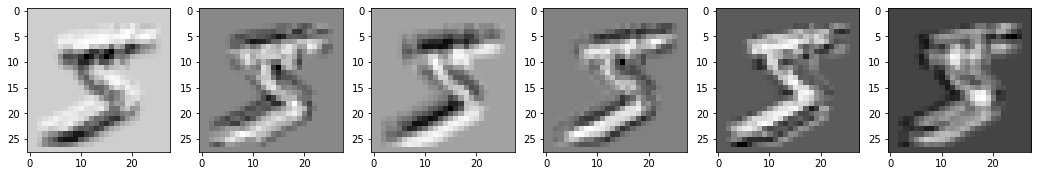

In [24]:
C1map = ConvNet.C1_FP[0]
fig, axarr = plt.subplots(1,6,figsize=(18,9))

for j in range(6):
    axarr[j].imshow(C1map[:,:,j], cmap=mpl.cm.Greys)

## Feature Maps of Layer1: Activation

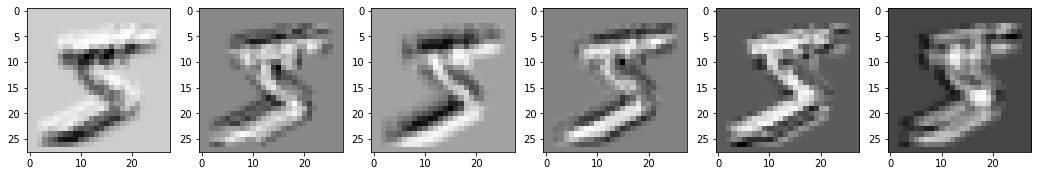

In [25]:
a1map = ConvNet.a1_FP[0]
fig, axarr = plt.subplots(1,6,figsize=(18,9))
for j in range(6):
    axarr[j].imshow(a1map[:,:,j], cmap=mpl.cm.Greys)

## Feature Maps of Subsampling S1

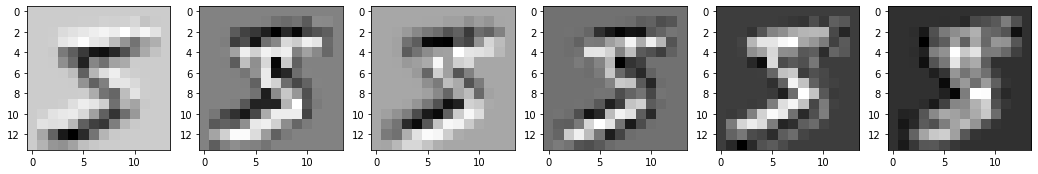

In [26]:
S2map = ConvNet.S2_FP[0]
fig, axarr = plt.subplots(1,6,figsize=(18,9))
for j in range(6):
    axarr[j].imshow(S2map[:,:,j], cmap=mpl.cm.Greys)

## Feature Maps of Conv_3

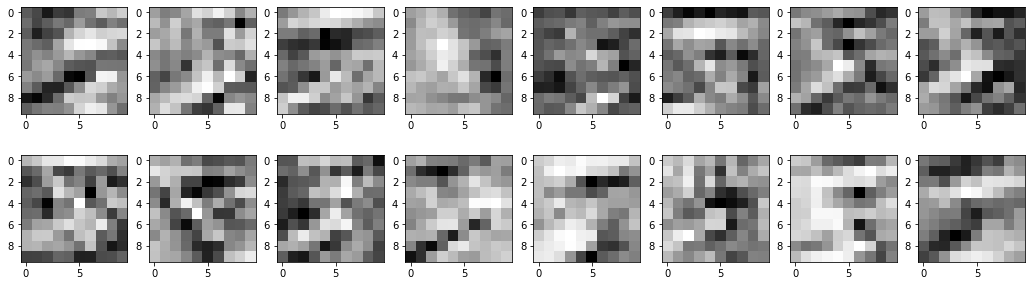

In [27]:
C3map = ConvNet.C3_FP[0]
fig, axarr = plt.subplots(2,8,figsize=(18,5))

for j in range(16):
    x,y = int(j/8), j%8
    axarr[x,y].imshow(C3map[:,:,j], cmap=mpl.cm.Greys)

## Feature Maps of Activation_2

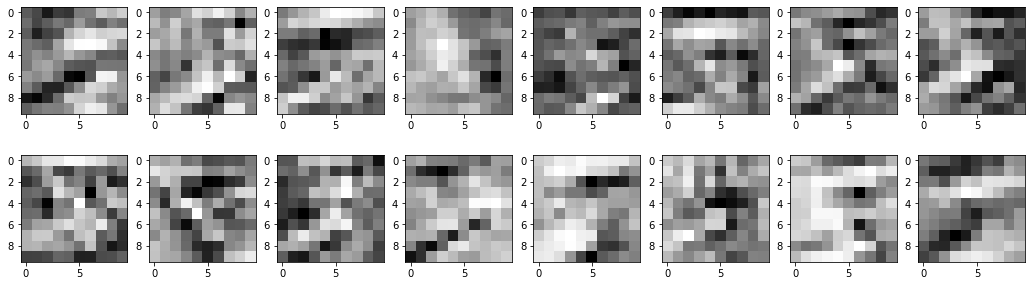

In [28]:
a2map = ConvNet.a2_FP[0]
fig, axarr = plt.subplots(2,8,figsize=(18,5))

for j in range(16):
    x,y = int(j/8), j%8
    axarr[x,y].imshow(a2map[:,:,j], cmap=mpl.cm.Greys)

## Feature Maps of Subsampling S4

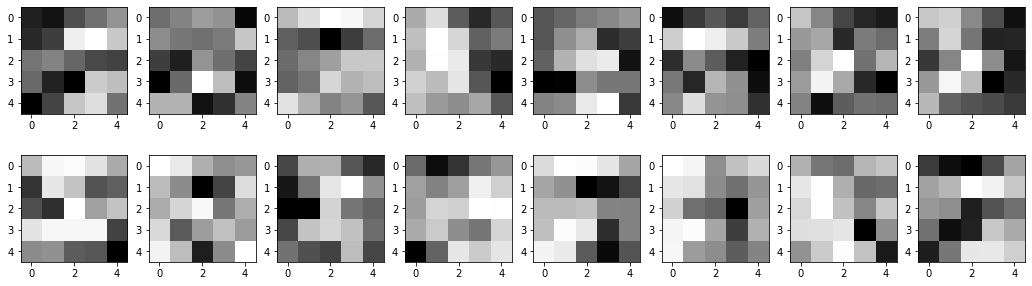

In [29]:
S4map = ConvNet.S4_FP[0]
fig, axarr = plt.subplots(2,8,figsize=(18,5))

for j in range(16):
    x,y = int(j/8), j%8
    axarr[x,y].imshow(S4map[:,:,j], cmap=mpl.cm.Greys)

Feature Maps of F6 and a4

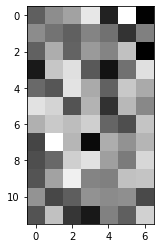

In [30]:
F6map = (ConvNet.F6_FP[0]).reshape(12,7)
plt.imshow(F6map, cmap=mpl.cm.Greys)

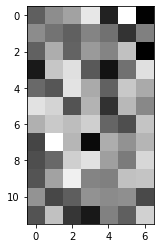

In [31]:
a4map = (ConvNet.a4_FP[0]).reshape(12,7)
plt.imshow(a4map, cmap=mpl.cm.Greys)